# Classification

_Erin Cameron_

---

In [ ]:
# Import the scikit learn library
# !pip3 install scikit-learn
# !pip install imbalanced-learn
# !pip install shap

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
# For Naive Bayes' binning of categorical features
from sklearn.preprocessing import KBinsDiscretizer
# t-SNE imports
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from collections import Counter
import shap

In [ ]:
# SMOTE imports
from imblearn.over_sampling import SMOTE

In [4]:
# Formatting settings for the environment
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) # To prevent truncation of long cell content

## 1.0) Format and Load Dataset

In [5]:
# Read in the formatted CSV file
print("Reading in data...")
data = pd.read_csv("./data/emergency_triage_data.csv")
print("Data read complete.")

Reading in data...
Data read complete.


In [6]:
display(data.head())

,Unnamed: 0,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage,CC_pain_trauma,CC_respiratory,CC_cardiovascular,CC_neurological,CC_gastrointestinal,CC_systemic_infectious,CC_other,DG_cardiovascular,DG_respiratory,DG_neurological,DG_gastrointestinal,DG_musculoskeletal_trauma,DG_infectious,DG_genitourinary,DG_other_systemic,DG_other,mistriage_original
0,0,2,2,71,3,3,2,right ocular pain,1,1,2,160.0,100.0,84.0,18.0,36.6,100.0,2,corneal abrasion,1,4,2,86,5.00,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,1,1,1,56,12,3,2,right forearm burn,1,1,2,137.0,75.0,60.0,20.0,36.5,NaN,4,burn of hand first degree dorsum,1,5,4,64,3.95,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,2,2,1,68,8,2,2,arm pain left,1,1,2,130.0,80.0,102.0,20.0,36.6,98.0,4,fracture of surgical neck of humerus closed,2,5,4,862,1.00,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,3,1,2,71,8,1,1,ascites tapping,1,1,3,139.0,94.0,88.0,20.0,36.5,NaN,4,alcoholic liver cirrhosis with ascites,1,5,6,108,9.83,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
4,4,1,2,58,4,3,1,distension abdominal,1,1,3,91.0,67.0,93.0,18.0,36.5,NaN,4,ascites,1,5,8,109,6.60,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [7]:
# Remove the "Unnamed: 0" column
data = data.drop(data.columns[0], axis=1)

In [8]:
display(data.head())

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage,CC_pain_trauma,CC_respiratory,CC_cardiovascular,CC_neurological,CC_gastrointestinal,CC_systemic_infectious,CC_other,DG_cardiovascular,DG_respiratory,DG_neurological,DG_gastrointestinal,DG_musculoskeletal_trauma,DG_infectious,DG_genitourinary,DG_other_systemic,DG_other,mistriage_original
0,2,2,71,3,3,2,right ocular pain,1,1,2,160.0,100.0,84.0,18.0,36.6,100.0,2,corneal abrasion,1,4,2,86,5.00,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,1,1,56,12,3,2,right forearm burn,1,1,2,137.0,75.0,60.0,20.0,36.5,NaN,4,burn of hand first degree dorsum,1,5,4,64,3.95,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,2,1,68,8,2,2,arm pain left,1,1,2,130.0,80.0,102.0,20.0,36.6,98.0,4,fracture of surgical neck of humerus closed,2,5,4,862,1.00,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,2,71,8,1,1,ascites tapping,1,1,3,139.0,94.0,88.0,20.0,36.5,NaN,4,alcoholic liver cirrhosis with ascites,1,5,6,108,9.83,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
4,1,2,58,4,3,1,distension abdominal,1,1,3,91.0,67.0,93.0,18.0,36.5,NaN,4,ascites,1,5,8,109,6.60,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


## 2.0) Define ML Train Features

Based on the relationship with the target variable (mistriage), the following features will be selected for modelling:

| Feature Name    | Type    | Predictor Strength | Key Observation from Data |
|---------------|-------|--------------------|---------------------------|
| KTAS_RN | Categorical/Ordinal | Strong | The proportion of mistriage increases significantly with the triage level, ranging from 42.3% at KTAS Level 1 to between 8.6% to 18.0% at all other KTAS Levels. This is a critical variable. |
| HR | Continuous | Strong | The mean pulse rate is noticeably higher for mistriaged patients (85.0) compared to correctly triaged patients (80.0). |
| Injury | Categorical (1 vs. 2) | Strong | Patients presenting with an Injury (1) had a higher proportion of mistriage (15.7%) compared to non-injury patients (10.7%). |
| Diagnosis in ED | Categorical/Nominal | Strong | The proportion of mistriage varies widely across the top 10 diagnoses, from as low as 4.8% (Ischaemic chest pain) to over 26% (Unspecified abdominal pain). This variance indicates high predictive power, but requires careful encoding. |
| Age | Continuous | Weak | The difference in mean age is minor (58.0 for mistriaged vs 56.5 for correctly triaged), but still present. |
| Other Physiological Variables    | Continuous | Weak | Variables like SBP, DBP, RR, and BT have very similar mean values - or identical - for both groups (e.g., RR is 20.0 vs 20.0). They may be redundant or add noise, this will be determined during classification steps. |
| Time Variables | Continuous | Weak | KTAS duration_min and Length of stay_min show very small differences in means. They may be redundant or add noise, this will be determined during classification steps. |

In [9]:
features = ['KTAS_RN', 'HR', 'Injury', 'Age', 'SBP',
            'DBP', 'RR', 'BT', 'KTAS duration_min', 'Length of stay_min',
            'CC_pain_trauma', 'CC_respiratory', 'CC_cardiovascular',
            'CC_neurological', 'CC_gastrointestinal', 'CC_systemic_infectious',
            'CC_other', 'DG_cardiovascular', 'DG_respiratory',
            'DG_neurological', 'DG_gastrointestinal', 'DG_musculoskeletal_trauma',
            'DG_infectious', 'DG_genitourinary', 'DG_other_systemic',
            'DG_other']

In [10]:
prediction_class = ['mistriage']

## 3.0) Subset Data

In [11]:
# Subset data to relevent discrete variables and prediction class
data = data[features + prediction_class]
# Display the data
data.head()

,KTAS_RN,HR,Injury,Age,SBP,DBP,RR,BT,KTAS duration_min,Length of stay_min,CC_pain_trauma,CC_respiratory,CC_cardiovascular,CC_neurological,CC_gastrointestinal,CC_systemic_infectious,CC_other,DG_cardiovascular,DG_respiratory,DG_neurological,DG_gastrointestinal,DG_musculoskeletal_trauma,DG_infectious,DG_genitourinary,DG_other_systemic,DG_other,mistriage
0,2,84.0,2,71,160.0,100.0,18.0,36.6,5.00,86,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,4,60.0,2,56,137.0,75.0,20.0,36.5,3.95,64,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,4,102.0,2,68,130.0,80.0,20.0,36.6,1.00,862,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,4,88.0,1,71,139.0,94.0,20.0,36.5,9.83,108,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
4,4,93.0,1,58,91.0,67.0,18.0,36.5,6.60,109,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [12]:
# Check number of mistriaged patients
print(data['mistriage'].value_counts())

mistriage
0    1066
1     184
Name: count, dtype: int64


In [13]:
# Drop any columns that have missing values for variables (if applicable)
print("Before dropping NAs...Mistriage Status Breakdown")
print(data['mistriage'].value_counts())
print(data.shape)

# Display mistriage status breakdown
print("\n\nAfter dropping NAs...Mistriage Status Breakdown")
data = data.dropna()
print(data['mistriage'].value_counts())
print(data.shape)

Before dropping NAs...Mistriage Status Breakdown
mistriage
0    1066
1     184
Name: count, dtype: int64
(1250, 27)


After dropping NAs...Mistriage Status Breakdown
mistriage
0    1042
1     174
Name: count, dtype: int64
(1216, 27)


## 4.0) Split into Test and Train

In [14]:
# Split the data into test and train
train_data, test_data = train_test_split(data, test_size = 0.20, random_state = 123)

In [15]:
# Check that train and test are correct size - train = 80%, test = 20%
print("\n\nTraining dataset....80% of original dataset")
print(train_data.shape)
display(train_data.head())

print("\n\nTest dataset....20% of original dataset")
print(test_data.shape)
display(test_data.head())



Training dataset....80% of original dataset
(972, 27)


,KTAS_RN,HR,Injury,Age,SBP,DBP,RR,BT,KTAS duration_min,Length of stay_min,CC_pain_trauma,CC_respiratory,CC_cardiovascular,CC_neurological,CC_gastrointestinal,CC_systemic_infectious,CC_other,DG_cardiovascular,DG_respiratory,DG_neurological,DG_gastrointestinal,DG_musculoskeletal_trauma,DG_infectious,DG_genitourinary,DG_other_systemic,DG_other,mistriage
895,3,66.0,1,36,157.0,100.0,22.0,36.0,4.67,277,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
924,3,51.0,1,44,139.0,86.0,16.0,36.2,6.23,249,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
500,4,76.0,1,51,120.0,70.0,20.0,36.1,1.00,113,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
651,4,72.0,2,75,109.0,65.0,20.0,36.0,7.85,48,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1131,3,110.0,1,76,100.0,70.0,20.0,36.5,1.00,340,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0




Test dataset....20% of original dataset
(244, 27)


,KTAS_RN,HR,Injury,Age,SBP,DBP,RR,BT,KTAS duration_min,Length of stay_min,CC_pain_trauma,CC_respiratory,CC_cardiovascular,CC_neurological,CC_gastrointestinal,CC_systemic_infectious,CC_other,DG_cardiovascular,DG_respiratory,DG_neurological,DG_gastrointestinal,DG_musculoskeletal_trauma,DG_infectious,DG_genitourinary,DG_other_systemic,DG_other,mistriage
694,2,62.0,1,58,110.0,60.0,20.0,36.2,4.00,274,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
582,3,98.0,1,31,91.0,54.0,18.0,36.9,6.08,180,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
684,2,64.0,1,50,120.0,60.0,20.0,36.5,3.00,9921,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
1111,4,63.0,1,74,147.0,74.0,18.0,36.3,3.40,545,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
897,4,68.0,1,37,110.0,60.0,20.0,36.3,4.00,210,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


## 5.0) Logistic Regression

### 5.1) Logistic Regression Data Preparation

All categorical variables have already been encoded as integer values in the column to be compatible with the logistic regression function.

In [16]:
# Columns that need One-Hot Encoding (OHE)
ohe_cols = ['KTAS_RN', 'Injury']

In [17]:
# Apply OHE to the remaining categorical columns
# Training data
train_data_lr = pd.get_dummies(train_data, columns=ohe_cols, drop_first=True)

# Test data
test_data_lr = pd.get_dummies(test_data, columns=ohe_cols, drop_first=True)

In [18]:
# Align the columns in both the test and train dataframes
train_cols = set(train_data_lr.columns)
test_cols = set(test_data_lr.columns)

# Find the columns that are missing in the test set and add them (filled with 0 values)
missing_in_test = list(train_cols - test_cols)
for c in missing_in_test:
    test_data_lr[c] = 0

# Find columns missing in the train set and add them (filled with 0 values)
missing_in_train = list(test_cols - train_cols)
for c in missing_in_train:
    train_data_lr[c] = 0

In [19]:
# Reorder the test columns to match the training columns
test_data_lr = test_data_lr[train_data_lr.columns]

In [20]:
# Target is 'mistriage' in both test and train datasets
Y_train = train_data_lr['mistriage']
Y_test = test_data_lr['mistriage']

In [21]:
# The features (X) are all other columns
X_train = train_data_lr.drop(columns=['mistriage'])
X_test = test_data_lr.drop(columns=['mistriage'])

In [22]:
# Final check of the shapes
print("\nFinal X and Y Data Shapes for Logistic Regression:")
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")


Final X and Y Data Shapes for Logistic Regression:
X_train shape: (972, 29)
Y_train shape: (972,)
X_test shape: (244, 29)
Y_test shape: (244,)


### 5.2) Build Logistic Regression model and predict

In [23]:
# Where X is sparse array of training data with feature,
# and Y is the classes (mistriaged 0/1) for each entry in training data
X = X_train
y = Y_train.values

In [24]:
# Fit the model on training data - using 'balanced' to address the class imbalance in mistriage column
# Use L1 regularization (LASSO) for penalizing the models coefficients for feature selection
logReg = LogisticRegression(random_state=123, max_iter=1000, penalty='l1', solver='liblinear', class_weight="balanced")
logReg = logReg.fit(X, y)

In [25]:
# Predict mistriage status on the testing data
predictions_logReg = logReg.predict(X_test)
# This is the probability for the positive class (1)
prediction_probabilities = logReg.predict_proba(X_test)[:, 1]

In [26]:
# Display the prediction counts
pred_0_count = list(predictions_logReg).count(0)
pred_1_count = list(predictions_logReg).count(1)
print("\n--- Prediction Counts ---")
print(f"Predicted Label 0 (Correct): {pred_0_count}")
print(f"Predicted Label 1 (Mistriage): {pred_1_count}")


--- Prediction Counts ---
Predicted Label 0 (Correct): 142
Predicted Label 1 (Mistriage): 102


### 5.3) Evaluate Logistic Regression model & predictions

In [27]:
# Print the classification report
print("\n--- Classification Report (Test Set) ---")
print(classification_report(Y_test, predictions_logReg))


--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.88      0.60      0.72       207
           1       0.20      0.54      0.29        37

    accuracy                           0.59       244
   macro avg       0.54      0.57      0.50       244
weighted avg       0.78      0.59      0.65       244



In [28]:
# Calculate the ROC-AUC score
auc_score = roc_auc_score(Y_test, prediction_probabilities)
print(f"ROC-AUC Score: {auc_score:.4f}")

ROC-AUC Score: 0.6100


In [29]:
# Save the predictions to file
prediction_results = test_data_lr['mistriage'].to_frame("Actual Label")
prediction_results = prediction_results.reset_index().rename(columns={"index": "Original Row Number"})
prediction_results["Predicited Label"] = predictions_logReg
prediction_results.insert(0, "Method", "LogisticRegression")
prediction_results.to_csv("./results/LogisiticRegression_Predictions.csv")
prediction_results.head(5)

,Method,Original Row Number,Actual Label,Predicited Label
0,LogisticRegression,694,0,1
1,LogisticRegression,582,0,0
2,LogisticRegression,684,0,1
3,LogisticRegression,1111,0,0
4,LogisticRegression,897,0,1


### 5.4) Assess model performance

Do all of our features used in the logisitic regression model contribute meaningful information when discerning mistriaged vs. correctly triaged patients? To assess this, we can look at the coefficient score of each feature in the model.

There are 952 features in the model.

Positive scores indicate a feature that predicts class 1, mistriaged patient in this case. Negative scores indicate a feature is predictive of class 2, correctly triaged patient in this case.

In [30]:
# Get feature importance (aka coefficient)
# higher absolute values mean the feature is more "important" and useful in telling classes apart (mistriaged vs correctly triaged)
# lower values close to 0 mean the feature is not very useful
featCoeffs = logReg.coef_.flatten()
featCoeffs = pd.DataFrame(featCoeffs, logReg.feature_names_in_).rename(columns={0: "Feature Coefficient"})
featCoeffs.describe()

,Feature Coefficient
count,29.000000
mean,-0.129248
std,0.478789
min,-1.217564
25%,-0.308855
50%,0.000000
75%,0.010926
max,1.028834


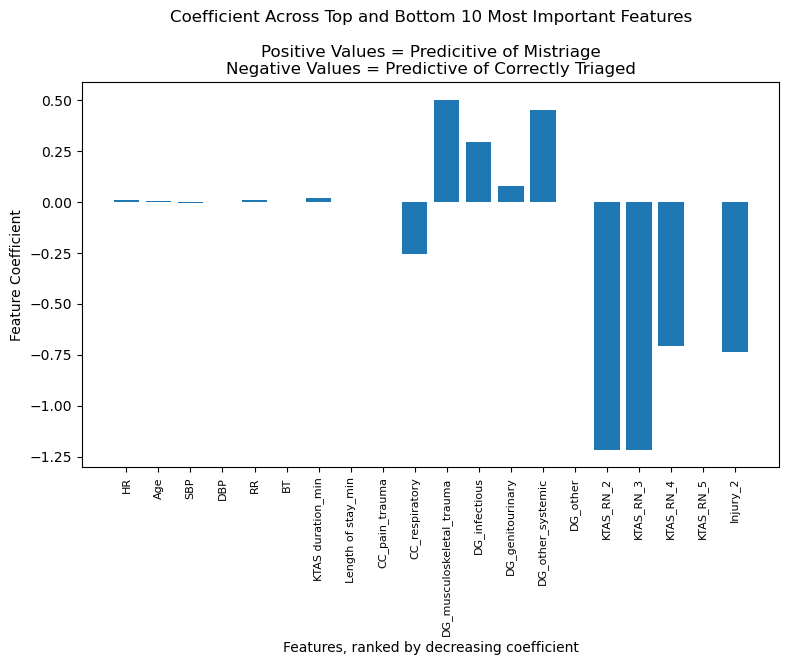

In [31]:
# Plot the top 10 features predictive of mistriaged patients (positive coefficients) and correctly triaged patients (negative coefficients)
nfeats = 10
top_N = pd.concat([featCoeffs.head(nfeats),featCoeffs.tail(nfeats)])
plt.figure(figsize = [9, 5])
plt.bar(top_N.index, top_N["Feature Coefficient"])
plt.xticks(fontsize = 8, rotation = 90)
plt.ylabel("Feature Coefficient")
plt.title("Coefficient Across Top and Bottom 10 Most Important Features\n\nPositive Values = Predicitive of Mistriage\nNegative Values = Predictive of Correctly Triaged")
plt.xlabel("Features, ranked by decreasing coefficient")
plt.show()

In [32]:
# save feature coeffs to file
featCoeffs = featCoeffs.reset_index().rename(columns={"index":"Feature"})
featCoeffs.insert(0, "Method", "LogisticRegression")
featCoeffs.to_csv("./results/LogisiticRegression_FeatureImportance.csv")
featCoeffs.head()

,Method,Feature,Feature Coefficient
0,LogisticRegression,HR,0.010926
1,LogisticRegression,Age,0.004391
2,LogisticRegression,SBP,-0.005503
3,LogisticRegression,DBP,0.002852
4,LogisticRegression,RR,0.008099


## 6.0) Naive Bayes

For the continuous variables we can either (1) exclude them or (2) trasform the continuous values into discrete values (ie, use tertiles to split values into high, medium and low catgeories instead of continuous values). For now, lets exclude the two cont variables.

    Gaussian Naive Bayes --> continuous variables, not appropiate for this use case since there is mainly categorical
    Bernoulli Naïve Bayes --> boolean categorical vairables, this is most appropiate for this data

**Discretization (Binning)**:   
The continuous features in this dataset (HR, Age, SBP, DBP, etc.) cannot be used directly in Bernoulli Naive Bayes without some adjustments. First, they need to be discretized (convert the range of continuous values into a few discrete categories (or bins)).
    
    Continuous Age (58, 31, 74) → Categorical Bins of 'Young', 'Middle', 'Senior'

Then, these bins must be converted into binary (0/1) columns using One-Hot Encoding.



Reference: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html (background) Reference: https://www.datacamp.com/tutorial/naive-bayes-scikit-learn (tutorial) Reference: https://www.kaggle.com/code/prashant111/naive-bayes-classifier-in-python

### 6.1) Naive Bayes Data Preparation

In [33]:
# Define the continuous features to bin
continuous_features = ['HR', 'Age', 'SBP', 'DBP', 'RR', 'BT', 
                       'KTAS duration_min', 'Length of stay_min']

In [34]:
# Make sure only the continuous features are selected for binning
X_train_cont = X_train[continuous_features]
X_test_cont = X_test[continuous_features]

In [35]:
# Using KBinsDiscretizer, convert continuous values into discrete bins - uniform (equal width bins), n_bins=5
# Set encode='onehot-dense' to directly create the binary columns needed for Bernoulli NB
discretizer = KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='uniform', subsample=None)

In [36]:
# Fit and transform the training data
X_train_binned = discretizer.fit_transform(X_train_cont)
X_train_binned = pd.DataFrame(X_train_binned, index=X_train_cont.index)

# Transform the test data (using the bins from the training data)
X_test_binned = discretizer.transform(X_test_cont)
X_test_binned = pd.DataFrame(X_test_binned, index=X_test_cont.index)

In [37]:
# Drop the original continuous features from the OHE X sets
X_train_final = X_train.drop(columns=continuous_features)
X_test_final = X_test.drop(columns=continuous_features)

In [38]:
# Concatenate the new binned features - which are already OHE'd
X_train_final = pd.concat([X_train_final, X_train_binned], axis=1)
X_test_final = pd.concat([X_test_final, X_test_binned], axis=1)

### 6.2) Build Naive Bayes' model & predict

In [39]:
# Initialize the model
# class_prior=None uses the actual proportions (0.85/0.15) for the imbalanced nature of the data - manually set balanced priors for imbalance
bnb = BernoulliNB(class_prior=[0.5, 0.5])

In [40]:
# Before fitting the model, force all column names to string type
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)
# Fit the model
bnb.fit(X_train_final, Y_train)

BernoulliNB(class_prior=[0.5, 0.5])

In [41]:
# Predict based on the test data
predictions_bnb = bnb.predict(X_test_final)
prediction_probabilities_bnb = bnb.predict_proba(X_test_final)[:, 1]

### 6.3) Evaluate Naive Bayes' model & predictions

In [42]:
# Display the classification report
print("\n--- Classification Report (Bernoulli Naive Bayes) ---")
print(classification_report(Y_test, predictions_bnb))


--- Classification Report (Bernoulli Naive Bayes) ---
              precision    recall  f1-score   support

           0       0.88      0.66      0.75       207
           1       0.20      0.49      0.29        37

    accuracy                           0.63       244
   macro avg       0.54      0.57      0.52       244
weighted avg       0.78      0.63      0.68       244



In [43]:
auc_score_bnb = roc_auc_score(Y_test, prediction_probabilities_bnb)
print(f"ROC-AUC Score: {auc_score_bnb:.4f}")

ROC-AUC Score: 0.6050


In [44]:
# Save the predictions to file
prediction_results = Y_test.to_frame("Actual Label")
prediction_results = prediction_results.reset_index().rename(columns={"index": "Original Row Number"})
prediction_results["Predicited Label"] = predictions_bnb
prediction_results.insert(0, "Method", "NaiveBayes")
prediction_results.to_csv("./results/NaiveBayes_Predictions.csv")
prediction_results.head(5)

,Method,Original Row Number,Actual Label,Predicited Label
0,NaiveBayes,694,0,0
1,NaiveBayes,582,0,1
2,NaiveBayes,684,0,1
3,NaiveBayes,1111,0,0
4,NaiveBayes,897,0,1


## 7.0) Random Forest

Similar to logistic regression, categorical variables need to be "one hot encodes" where we turn each value in a column into its own boolean column. We use one hot because the values within a feature does not have a ranking relationship.

### 7.1) One-hot encode categorical variables

In [45]:
# One-hot encoding has already been completed above, reusing the dataframes here
train_data_rf = train_data_lr
test_data_rf = test_data_lr

### 7.2) Build Random Forest model & predict

In [46]:
# Initialize the RF classifier
rf_model = RandomForestClassifier(n_estimators=300, max_depth=10, class_weight="balanced", random_state=123)

In [47]:
# Fit the model
rf_model.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=300,
                       random_state=123)

In [48]:
# Predict
predictions_rf = rf_model.predict(X_test)
# Probability for the positive class (1)
prediction_probabilities_rf = rf_model.predict_proba(X_test)[:, 1]

### 7.3) Evaluate Random Forest model & predictions

In [49]:
# Display the classification report
print("\n--- Classification Report (Random Forest - Test Set) ---")
print(classification_report(Y_test, predictions_rf))


--- Classification Report (Random Forest - Test Set) ---
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       207
           1       0.17      0.03      0.05        37

    accuracy                           0.83       244
   macro avg       0.51      0.50      0.48       244
weighted avg       0.75      0.83      0.78       244



In [50]:
# Calculate ROC-AUC score
auc_score_rf = roc_auc_score(Y_test, prediction_probabilities_rf)
print(f"ROC-AUC Score: {auc_score_rf:.4f}")

ROC-AUC Score: 0.6611


In [51]:
# Save the predictions to file
prediction_results = Y_test.to_frame("Actual Label")
prediction_results = prediction_results.reset_index().rename(columns={"index": "Original Row Number"})
prediction_results["Predicited Label"] = predictions_rf
prediction_results.insert(0, "Method", "RandomForest")
prediction_results.to_csv("./results/RandomForest_Predictions.csv")
prediction_results.head(5)

,Method,Original Row Number,Actual Label,Predicited Label
0,RandomForest,694,0,0
1,RandomForest,582,0,0
2,RandomForest,684,0,0
3,RandomForest,1111,0,0
4,RandomForest,897,0,0


### 7.4) Mean Decrease in Impurity (MDI)

In [52]:
# Get feature importances and standard deviation from the RF model
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

In [53]:
# Turn into dataframe
feature_importances = pd.Series(importances, index=X_train.columns)
feature_importances_rf = feature_importances.to_frame("FeatureImportance_MDI")
feature_importances_rf["std"] = std
feature_importances_rf.head(3)

,FeatureImportance_MDI,std
HR,0.117165,0.04654
Age,0.103080,0.04114
SBP,0.088170,0.03622


In [54]:
# Save feature coefficients to file
feature_importances_rf = feature_importances_rf.reset_index().rename(columns={"index":"Feature"})
feature_importances_rf.insert(0, "Method", "RandomForest_MDI")
feature_importances_rf.to_csv("./results/RandomForest_MDI_FeatureImportance.csv")
feature_importances_rf.head()

,Method,Feature,FeatureImportance_MDI,std
0,RandomForest_MDI,HR,0.117165,0.046540
1,RandomForest_MDI,Age,0.103080,0.041140
2,RandomForest_MDI,SBP,0.088170,0.036220
3,RandomForest_MDI,DBP,0.090390,0.041658
4,RandomForest_MDI,RR,0.040446,0.024810


### 7.5) SHAP

In [146]:
# Check all columns are numerical
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 694 to 1220
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HR                         244 non-null    float64
 1   Age                        244 non-null    int64  
 2   SBP                        244 non-null    float64
 3   DBP                        244 non-null    float64
 4   RR                         244 non-null    float64
 5   BT                         244 non-null    float64
 6   KTAS duration_min          244 non-null    float64
 7   Length of stay_min         244 non-null    int64  
 8   CC_pain_trauma             244 non-null    int64  
 9   CC_respiratory             244 non-null    int64  
 10  CC_cardiovascular          244 non-null    int64  
 11  CC_neurological            244 non-null    int64  
 12  CC_gastrointestinal        244 non-null    int64  
 13  CC_systemic_infectious     244 non-null    int64  
 

In [147]:
# Convert columns to numerical values
# Copy the dataframe into another variable first
X_test_int = X_test
X_test_int['KTAS_RN_2'] = X_test_int['KTAS_RN_2'].astype(int)
X_test_int['KTAS_RN_3'] = X_test_int['KTAS_RN_3'].astype(int)
X_test_int['KTAS_RN_4'] = X_test_int['KTAS_RN_4'].astype(int)
X_test_int['KTAS_RN_5'] = X_test_int['KTAS_RN_5'].astype(int)
X_test_int['Injury_2'] = X_test_int['Injury_2'].astype(int)

In [148]:
# Check all variables are numerical
print(X_test_int.info())

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 694 to 1220
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HR                         244 non-null    float64
 1   Age                        244 non-null    int64  
 2   SBP                        244 non-null    float64
 3   DBP                        244 non-null    float64
 4   RR                         244 non-null    float64
 5   BT                         244 non-null    float64
 6   KTAS duration_min          244 non-null    float64
 7   Length of stay_min         244 non-null    int64  
 8   CC_pain_trauma             244 non-null    int64  
 9   CC_respiratory             244 non-null    int64  
 10  CC_cardiovascular          244 non-null    int64  
 11  CC_neurological            244 non-null    int64  
 12  CC_gastrointestinal        244 non-null    int64  
 13  CC_systemic_infectious     244 non-null    int64  
 

In [175]:
# Initialize
rf_explainer = shap.TreeExplainer(rf_model)

In [176]:
rf_values = rf_explainer.shap_values(
    X_test_int,
    check_additivity=False
)

In [177]:
# Collapse the last dimension - class 1 (mistriage)
rf_values = rf_values[:, :, 1]

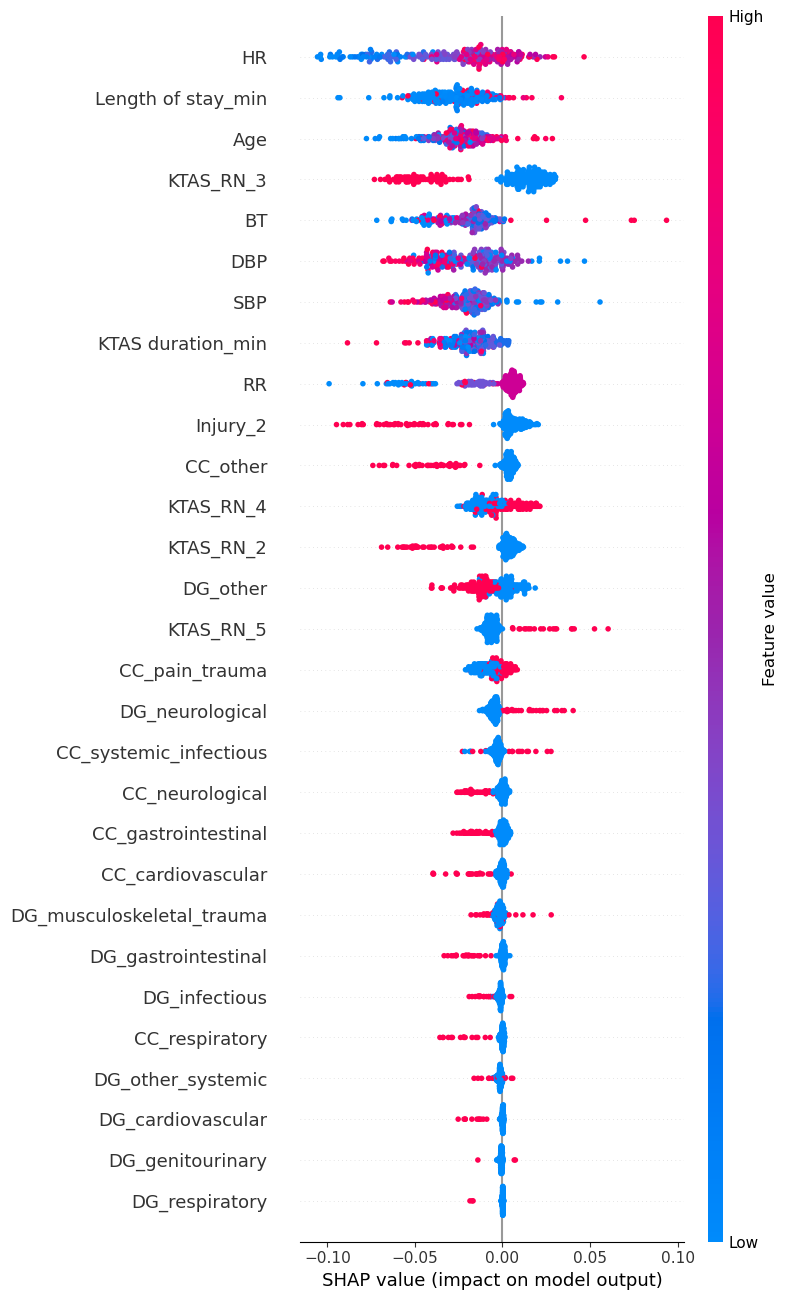

In [182]:
# Plot the SHAP plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    rf_values,
    X_test_int,
    plot_type = "dot",
    max_display = 29,
    show = False
    )
plt.tight_layout()
plt.savefig("./results/shap_summary_mistriage_class1.png", dpi=300, bbox_inches="tight")
plt.show()

## 8.0) Unsupervised Clustering with t-SNE

t-SNE (t-Distributed Stochastic Neighbor Embedding):   
A powerful tool for unsupervised exploration, allowing determination of high-dimensional data naturally separates patients into groups that align with their triage outcome.

In [55]:
# Recombine the data for a full feature matrix (X) and target (Y) (X and Y data from the test and train splits)
X_full = pd.concat([X_train, X_test], axis=0)
Y_full = pd.concat([Y_train, Y_test], axis=0)

In [56]:
# Scale all features because t-SNE is sensitive to feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

In [57]:
print(f"Original Feature Count: {X_scaled.shape[1]}")

Original Feature Count: 29


In [58]:
# Initialize t-SNE with n_components=2 for 2D visualization
tsne = TSNE(
    n_components=2, 
    perplexity=30, # controls the balance between local and global data structure (typically between 5 to 50)
    learning_rate='auto', 
    n_iter=1000, 
    random_state=123
)

In [59]:
# Apply t-SNE to the scaled data
X_tsne = tsne.fit_transform(X_scaled)
X_tsne = pd.DataFrame(X_tsne, columns=['TSNE_1', 'TSNE_2'], index=Y_full.index)

/Users/erincameron/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [60]:
# Merge the mistriage labels (true) with the projected data
df_tsne = X_tsne.copy()
df_tsne['mistriage'] = Y_full.values

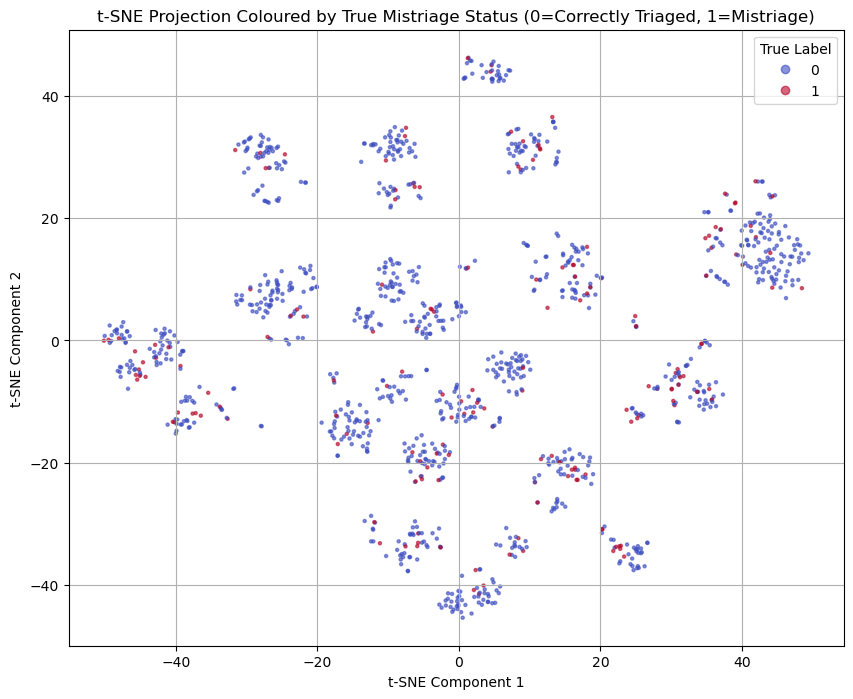

In [61]:
# Plot the 2D t-SNE visualization colored by the true mistriage label
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_tsne['TSNE_1'], 
    df_tsne['TSNE_2'], 
    c=df_tsne['mistriage'], 
    cmap='coolwarm', 
    alpha=0.6, 
    s=5
)
plt.title('t-SNE Projection Coloured by True Mistriage Status (0=Correctly Triaged, 1=Mistriage)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(*scatter.legend_elements(), title="True Label")
plt.grid(True)
plt.savefig('./results/t-SNE.png') 
plt.show()

In [62]:
# K-means for purity score - k=2 because we have two true classes (0 and 1)
kmeans = KMeans(n_clusters=2, random_state=123, n_init='auto')

In [63]:
# Fit K-means to the 2D projected data
kmeans.fit(X_tsne[['TSNE_1', 'TSNE_2']])
cluster_labels = kmeans.labels_

In [64]:
# Function to map the purity score K-means cluster labels to true labels
def cluster_purity_score(true_labels, cluster_labels):
    """Calculates the purity score"""
    # Build a confusion matrix between the true labels and cluster labels
    # Shape is (k_true, k_clusters) = (2, 2)
    matrix = confusion_matrix(true_labels, cluster_labels)
    
    # Sum the max value in each true class row (how many points in that class were assigned to their majority cluster)
    purity = np.sum(np.amax(matrix, axis=0)) / np.sum(matrix)
    return purity

In [65]:
# Since the K-means labels (0, 1) might be inverted compared to the true labels (0, 1), 
# the score calculation should be provided (takes the highest count alignment)
purity_score = cluster_purity_score(Y_full, cluster_labels)

In [66]:
# Display results
print("\n--- Unsupervised Clustering Results ---")
print(f"Purity Score (Alignment with True Mistriage Labels): {purity_score:.4f}")


--- Unsupervised Clustering Results ---
Purity Score (Alignment with True Mistriage Labels): 0.8569


## 9.0) SMOTE

SMOTE (Synthetic Minority Over-sampling Technique):   
The high purity score calculated above (≈0.8569) confirms the features are strong, but the collapse in the Random Forest model's recall value of 0.03 suggests that the model is prioritizing the majority class. The solution to this is SMOTE: to force the model to learn the minority class.

In [67]:
# Confirm the original class balance
print("--- Original Training Data Balance ---")
print(Counter(Y_train))

--- Original Training Data Balance ---
Counter({0: 835, 1: 137})


In [72]:
# Initialize SMOTE and apply to the training data
sm = SMOTE(sampling_strategy='minority', # sampling_strategy='minority' to only balance the minority class to match the count of the majority class
           random_state=123)

In [73]:
# Fit SMOTE on X_train and Y_train to generate the synthetic data
X_train_smote, Y_train_smote = sm.fit_resample(X_train, Y_train)

In [74]:
# Display distribution results
print("\n--- SMOTE Balanced Training Data Balance ---")
print(Counter(Y_train_smote))

print(f"\nOriginal Training Set size: {X_train.shape[0]}")
print(f"SMOTE Training Set size: {X_train_smote.shape[0]}")


--- SMOTE Balanced Training Data Balance ---
Counter({0: 835, 1: 835})

Original Training Set size: 972
SMOTE Training Set size: 1670


### 9.1) Re-run Random Forest model using SMOTE data (`X_train_smote`, `Y_train_smote`)

In [75]:
# Initialize the RF classifier (remove class_weight="balanced" since SMOTE artificially balances the dataset)
rf_model_smote = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=123)

In [76]:
# Fit the model
rf_model_smote.fit(X_train_smote, Y_train_smote)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=123)

In [77]:
# Predict
predictions_rf_smote = rf_model_smote.predict(X_test)
# Probability for the positive class (1)
prediction_probabilities_rf_smote = rf_model_smote.predict_proba(X_test)[:, 1]

In [78]:
# Display the classification report
print("\n--- Classification Report (Random Forest SMOTE - Test Set) ---")
print(classification_report(Y_test, predictions_rf_smote))


--- Classification Report (Random Forest SMOTE - Test Set) ---
              precision    recall  f1-score   support

           0       0.85      0.97      0.90       207
           1       0.22      0.05      0.09        37

    accuracy                           0.83       244
   macro avg       0.54      0.51      0.50       244
weighted avg       0.76      0.83      0.78       244



In [79]:
# Calculate ROC-AUC score
auc_score_rf = roc_auc_score(Y_test, prediction_probabilities_rf_smote)
print(f"ROC-AUC Score: {auc_score_rf:.4f}")

ROC-AUC Score: 0.6766


In [80]:
# Save the predictions to file
prediction_results = Y_test.to_frame("Actual Label")
prediction_results = prediction_results.reset_index().rename(columns={"index": "Original Row Number"})
prediction_results["Predicited Label"] = predictions_rf_smote
prediction_results.insert(0, "Method", "RandomForest")
prediction_results.to_csv("./results/RandomForest_SMOTE_Predictions.csv")
prediction_results.head(5)

,Method,Original Row Number,Actual Label,Predicited Label
0,RandomForest,694,0,0
1,RandomForest,582,0,0
2,RandomForest,684,0,0
3,RandomForest,1111,0,0
4,RandomForest,897,0,1


### 9.2) Random Forest with SMOTE feature importance

In [81]:
feature_importance_rf_smote = pd.Series(rf_model_smote.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Display the top 10
print("\n--- Top 10 Feature Importances (Random Forest with SMOTE)---")
print(feature_importance_rf_smote.head(10))


--- Top 10 Feature Importances (Random Forest with SMOTE)---
KTAS_RN_4             0.076907
Length of stay_min    0.067754
RR                    0.066148
BT                    0.064572
CC_other              0.058620
HR                    0.054011
KTAS duration_min     0.051477
DG_other              0.051115
DBP                   0.049265
Age                   0.048747
dtype: float64


## 10.0) Random Forest - Pruned Feature Set

The feature importance analysis reveals two key issues:

    There are features that were initially assessed as "Weak" (like Length of stay_min, RR, BT). These features are still dominating the model, causing noise.
    The CC_ and DG_ categories are ranked too low.

In this step I will prune the noise and force the random forest model to focus on the strongest, relevant features.

In [82]:
train_data_lr.head(10)

,HR,Age,SBP,DBP,RR,BT,KTAS duration_min,Length of stay_min,CC_pain_trauma,CC_respiratory,CC_cardiovascular,CC_neurological,CC_gastrointestinal,CC_systemic_infectious,CC_other,DG_cardiovascular,DG_respiratory,DG_neurological,DG_gastrointestinal,DG_musculoskeletal_trauma,DG_infectious,DG_genitourinary,DG_other_systemic,DG_other,mistriage,KTAS_RN_2,KTAS_RN_3,KTAS_RN_4,KTAS_RN_5,Injury_2
895,66.0,36,157.0,100.0,22.0,36.0,4.67,277,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,False,True,False,False,False
924,51.0,44,139.0,86.0,16.0,36.2,6.23,249,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,False,True,False,False,False
500,76.0,51,120.0,70.0,20.0,36.1,1.00,113,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,False,True,False,False
651,72.0,75,109.0,65.0,20.0,36.0,7.85,48,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,False,True,False,True
1131,110.0,76,100.0,70.0,20.0,36.5,1.00,340,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,False,True,False,False,False
1078,78.0,69,150.0,90.0,20.0,36.8,4.00,268,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,False,False,True,False,False
209,74.0,61,130.0,80.0,20.0,37.6,4.00,555,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,False,False,True,False,False
150,140.0,63,110.0,70.0,24.0,36.2,4.00,8188,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,False,True,False,False,False
716,56.0,53,116.0,61.0,16.0,35.6,4.07,164,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,False,True,False,False,False
635,93.0,67,134.0,89.0,20.0,36.8,4.58,122,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,False,True,False,False,False


In [83]:
# Select only the high-signal features from the data
final_pruned_features = [
    # Core vital signs / demographics
    'HR', 'Age', 'SBP', 'DBP',
    'Injury_2',
    
    # All KTAS OHE columns
    'KTAS_RN_2', 'KTAS_RN_3', 'KTAS_RN_4', 'KTAS_RN_5', 
    
    # CC categories (exclude CC_other)
    'CC_pain_trauma', 'CC_respiratory', 'CC_cardiovascular', 'CC_neurological', 
    'CC_gastrointestinal', 'CC_systemic_infectious', 
    
    # DG categories (exclude DG_other)
    'DG_cardiovascular', 'DG_respiratory', 'DG_neurological', 'DG_gastrointestinal', 
    'DG_musculoskeletal_trauma', 'DG_infectious', 'DG_genitourinary', 
    'DG_other_systemic'
]

In [84]:
# Ensure only the selected features are used in the final matrices
X_train_pruned = X_train_smote[final_pruned_features]
X_test_pruned = X_test[final_pruned_features]

In [85]:
# Initialize and fit the model without class_weight="balanced" since SMOTE was applied
rf_model_pruned = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=123, n_jobs=-1 )
rf_model_pruned.fit(X_train_pruned, Y_train_smote)

RandomForestClassifier(max_depth=10, n_estimators=300, n_jobs=-1,
                       random_state=123)

In [86]:
# Predict
predictions_rf_pruned = rf_model_pruned.predict(X_test_pruned)
probabilities_rf_pruned = rf_model_pruned.predict_proba(X_test_pruned)[:, 1] 

In [87]:
# Display the classification report
print("\n--- Classification Report (Random Forest PRUNED + SMOTE) ---")
print(classification_report(Y_test, predictions_rf_pruned))


--- Classification Report (Random Forest PRUNED + SMOTE) ---
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       207
           1       0.15      0.14      0.14        37

    accuracy                           0.75       244
   macro avg       0.50      0.50      0.50       244
weighted avg       0.74      0.75      0.75       244



In [88]:
auc_score_final = roc_auc_score(Y_test, probabilities_rf_pruned)
print(f"ROC-AUC Score: {auc_score_final:.4f}")

ROC-AUC Score: 0.6020


#### 10.1) SHAP plot

In [93]:
# Initialize the TreeExplainer with the final RF model
explainer = shap.TreeExplainer(rf_model_pruned)

In [94]:
# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_pruned)

In [95]:
# Target the mistriage outcome (class 1)
shap_values_mistriage = shap_values[1]

In [96]:
# Error workaround: "The shape of the shap_values matrix does not match the shape of the provided data matrix"
# Isolate the data values as a NumPy array (removes DataFrame metadata)
X_test_values = X_test_pruned.values
# Get the feature names list explicitly
feature_names_list = list(X_test_pruned.columns)

In [97]:
# Generate the SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_mistriage, 
    X_test_values,
    feature_names=feature_names_list,
    show=False,
    plot_type="dot", 
    title="SHAP Feature Importance for Mistriage (Class 1)",
    max_display=15
)
plt.tight_layout()
plt.savefig('SHAP_Summary_Plot.png')
plt.show()

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1000x800 with 0 Axes>